# Multi-cell geolift analysis

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

import causalpy as cp
from causalpy.data.simulate_data import (
    generate_multicell_geolift_data,
)

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
pd.set_option("display.precision", 2)
seed = 42

---
## TEMP - generate data

This section will be removed once the synthetic data generation is implemented. Then we can just use `cp.load_data`.

In [3]:
df = generate_multicell_geolift_data()

In [4]:
df.to_csv("../../../causalpy/data/geolift_multi_cell.csv", index=True)

---

In [5]:
cp.load_data("geolift_multi_cell")

,time,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,t1,t2,t3,t4
0,2019-01-06,3.02,1.73,4.14,3.50,3.11,2.05,3.58,3.09,3.10,3.37
1,2019-01-13,3.14,1.74,3.93,3.79,3.50,2.01,3.46,3.00,3.20,3.48
2,2019-01-20,2.79,1.73,4.07,3.75,3.32,1.94,3.49,3.16,2.94,3.15
3,2019-01-27,2.96,1.73,4.24,3.69,3.28,2.02,3.32,2.91,3.13,3.28
4,2019-02-03,2.80,1.83,4.20,3.63,3.02,2.33,3.34,3.13,2.94,3.25
...,...,...,...,...,...,...,...,...,...,...,...
203,2022-11-27,2.89,1.80,4.38,3.14,3.82,1.60,4.11,2.84,3.31,3.66
204,2022-12-04,3.21,1.71,4.37,3.30,3.64,2.02,3.75,3.19,3.49,3.61
205,2022-12-11,2.92,1.60,4.31,3.44,3.65,1.83,3.74,3.26,3.38,3.45
206,2022-12-18,3.09,1.73,4.44,3.44,3.60,1.83,3.80,3.09,3.35,3.45


In [6]:
df = (
    cp.load_data("geolift_multi_cell")
    .assign(time=lambda x: pd.to_datetime(x["time"]))
    .set_index("time")
)

treatment_time = pd.to_datetime("2022-01-01")
df.head()

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,t1,t2,t3,t4
time,,,,,,,,,,
2019-01-06,3.02,1.73,4.14,3.50,3.11,2.05,3.58,3.09,3.10,3.37
2019-01-13,3.14,1.74,3.93,3.79,3.50,2.01,3.46,3.00,3.20,3.48
2019-01-20,2.79,1.73,4.07,3.75,3.32,1.94,3.49,3.16,2.94,3.15
2019-01-27,2.96,1.73,4.24,3.69,3.28,2.02,3.32,2.91,3.13,3.28
2019-02-03,2.80,1.83,4.20,3.63,3.02,2.33,3.34,3.13,2.94,3.25


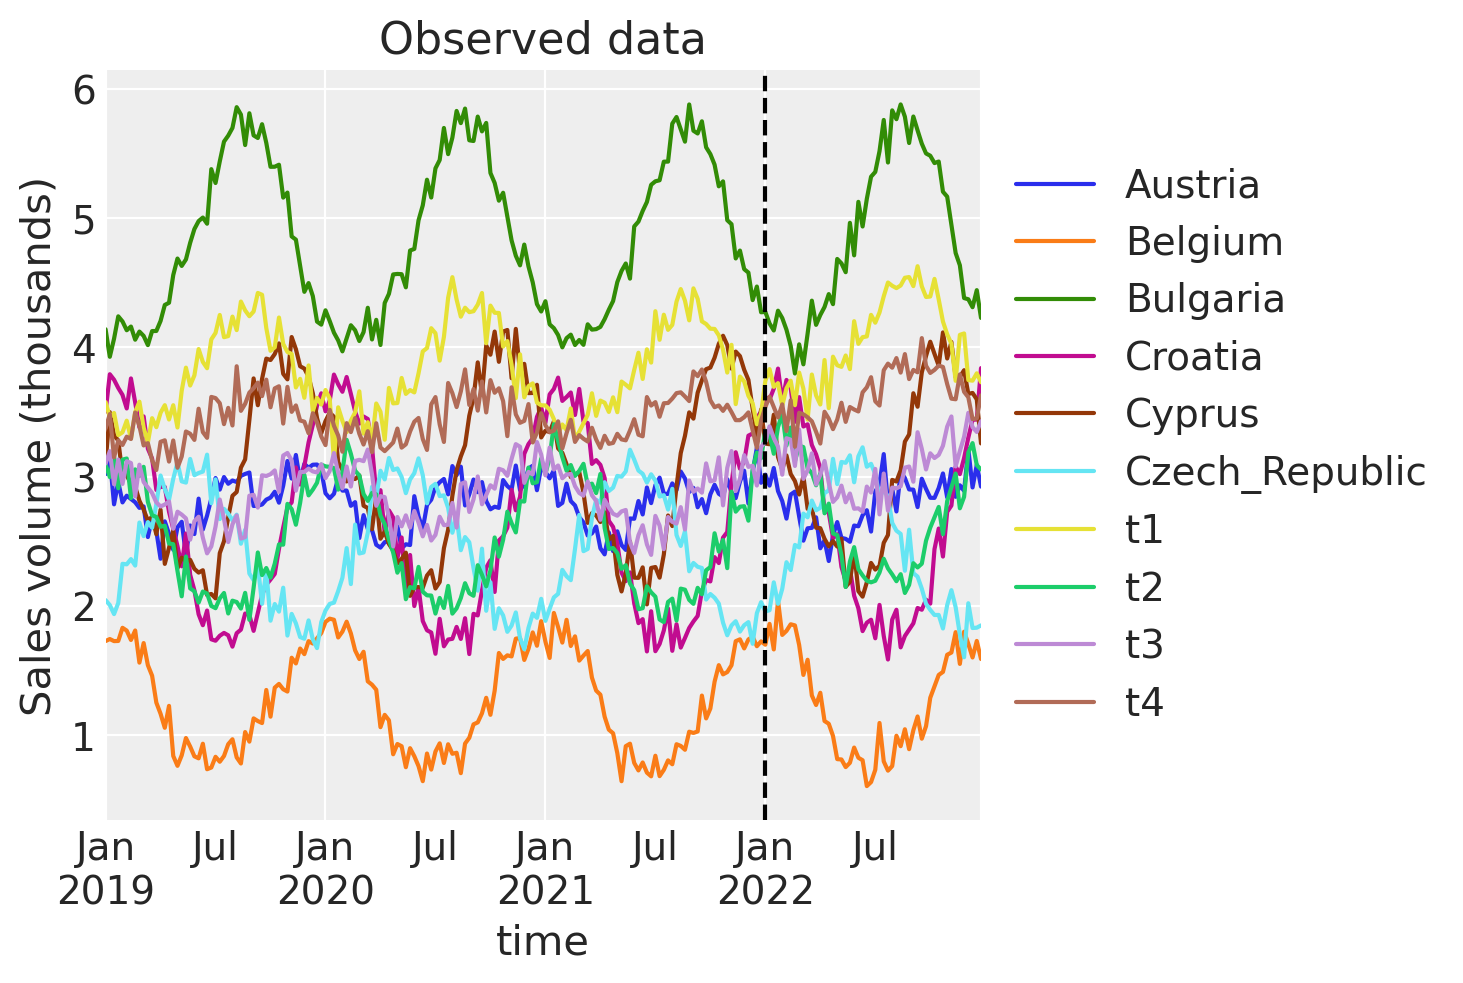

In [7]:
ax = df.plot()
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data", ylabel="Sales volume (thousands)")
# set the legend location to outside right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [8]:
untreated = [
        "Austria",
        "Belgium",
        "Bulgaria",
        "Croatia",
        "Cyprus",
        "Czech_Republic",
    ]

treated = ["t1", "t2", "t3", "t4"]

## Analysis 1 - individual geo approach

The first analysis approach is to analyze each treated geo individually.

In [9]:
results = []

for i, target_geo in enumerate(treated):
    
    print(f"Analyzing test geo: {target_geo} ({i+1} of {len(treated)})")
    formula = f"{target_geo} ~ 0 + {' + '.join(untreated)}"
    print(formula)
    
    result = cp.pymc_experiments.SyntheticControl(
        df,
        treatment_time,
        formula=formula,
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={"target_accept": 0.95, "random_seed": seed}
        ),
    )
    results.append(result) 

Analyzing test geo: t1 (1 of 4)
t1 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t2 (2 of 4)
t2 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t3 (3 of 4)
t3 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t4 (4 of 4)
t4 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Now let's plot the weightings of the untreated geos for each treated geo.

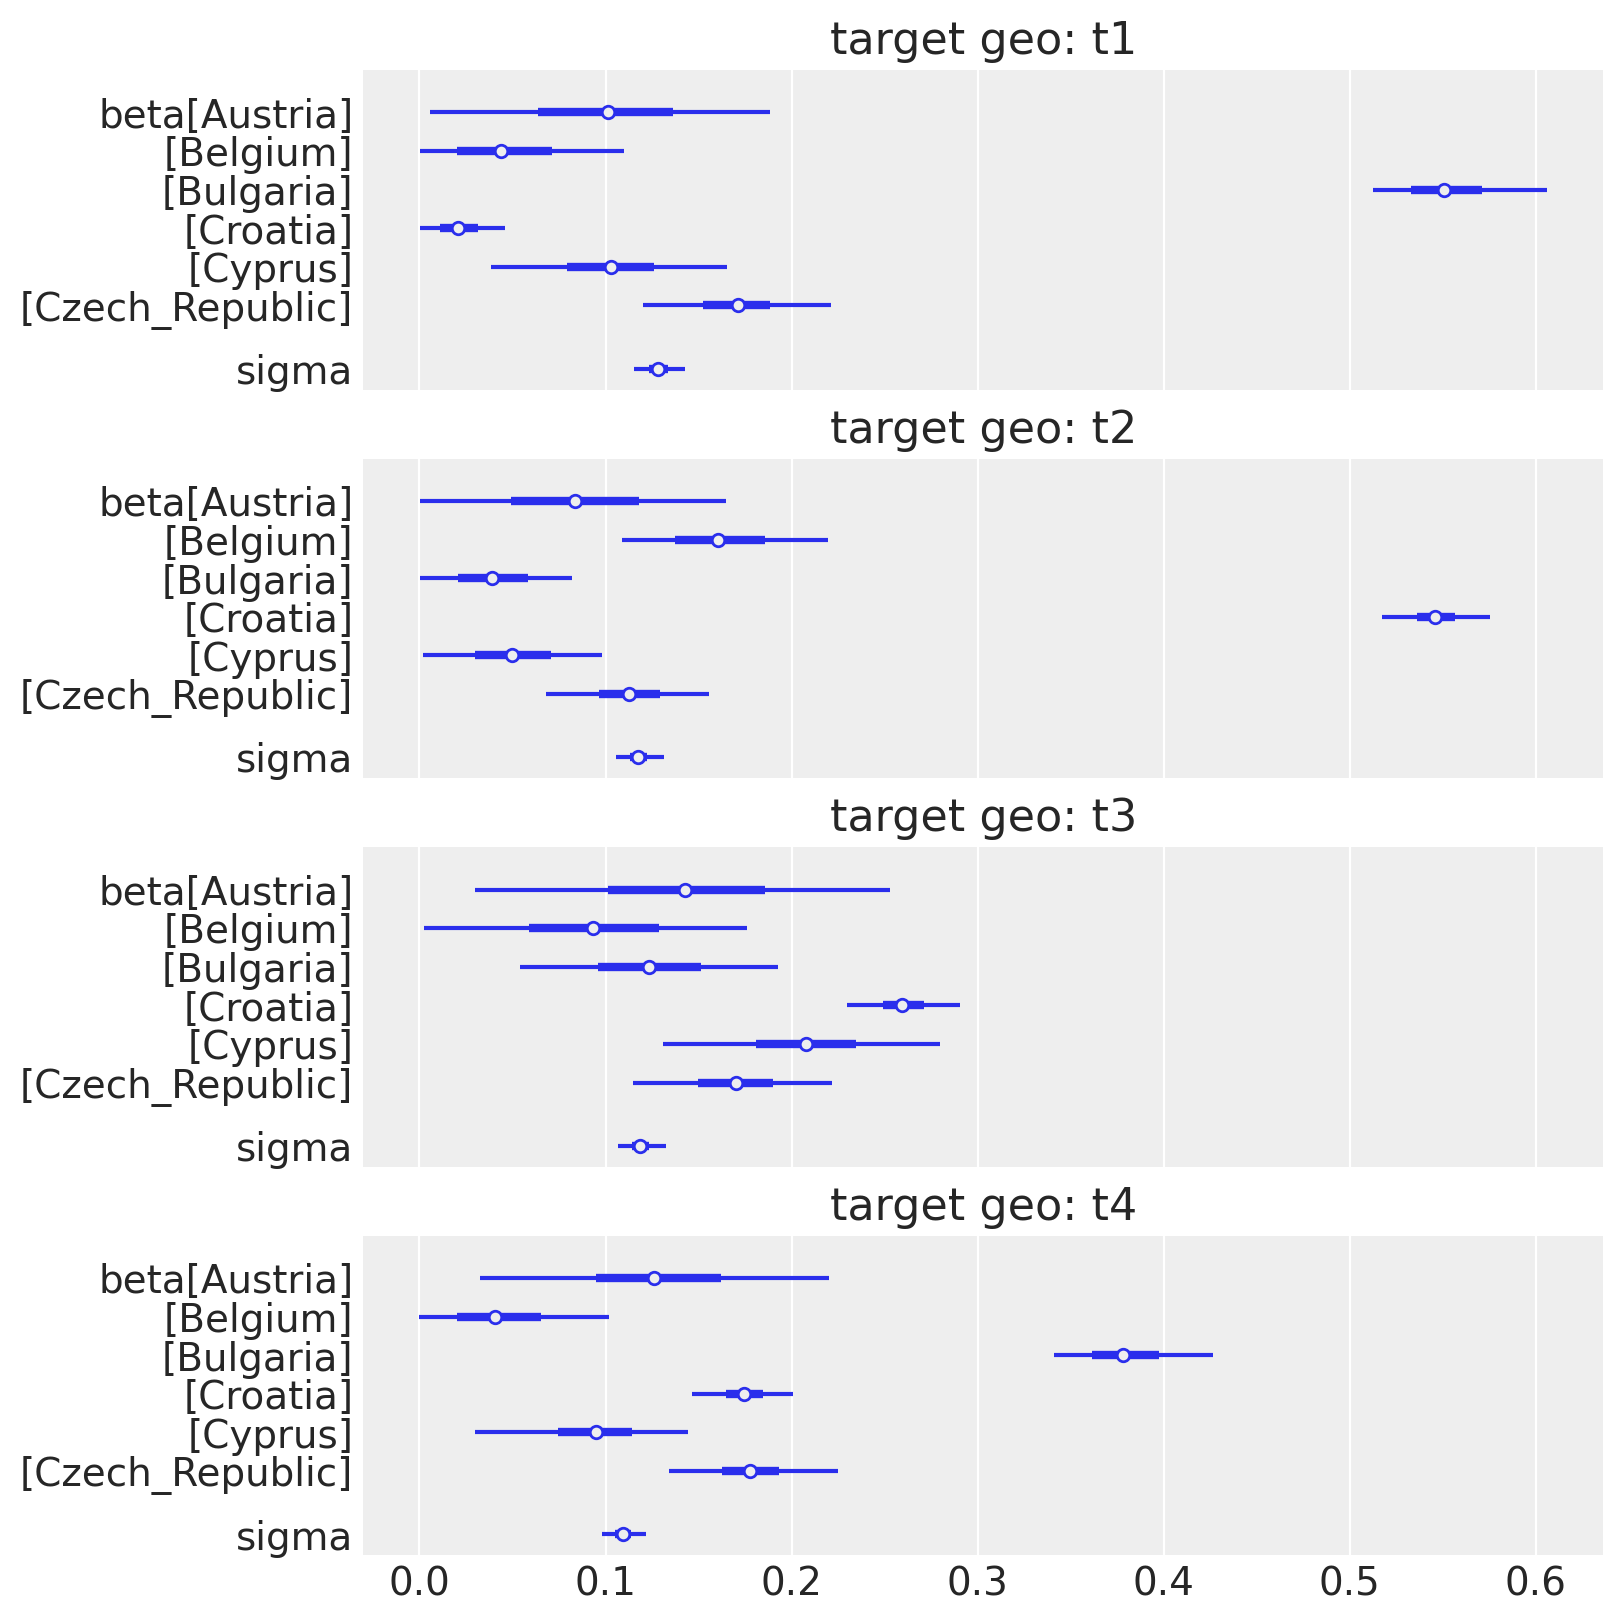

In [10]:
fig, axs = plt.subplots(len(treated), 1, figsize=(8, 2*len(treated)), sharex=True)

for target_geo, ax, result in zip(treated, axs, results):
    az.plot_forest(result.idata, var_names=["~mu"], combined=True, ax=ax)
    ax.set(title=f"target geo: {target_geo}")

And let's also plot the idiomatic causal impact plot for each treated geo.

Causal impact for t1


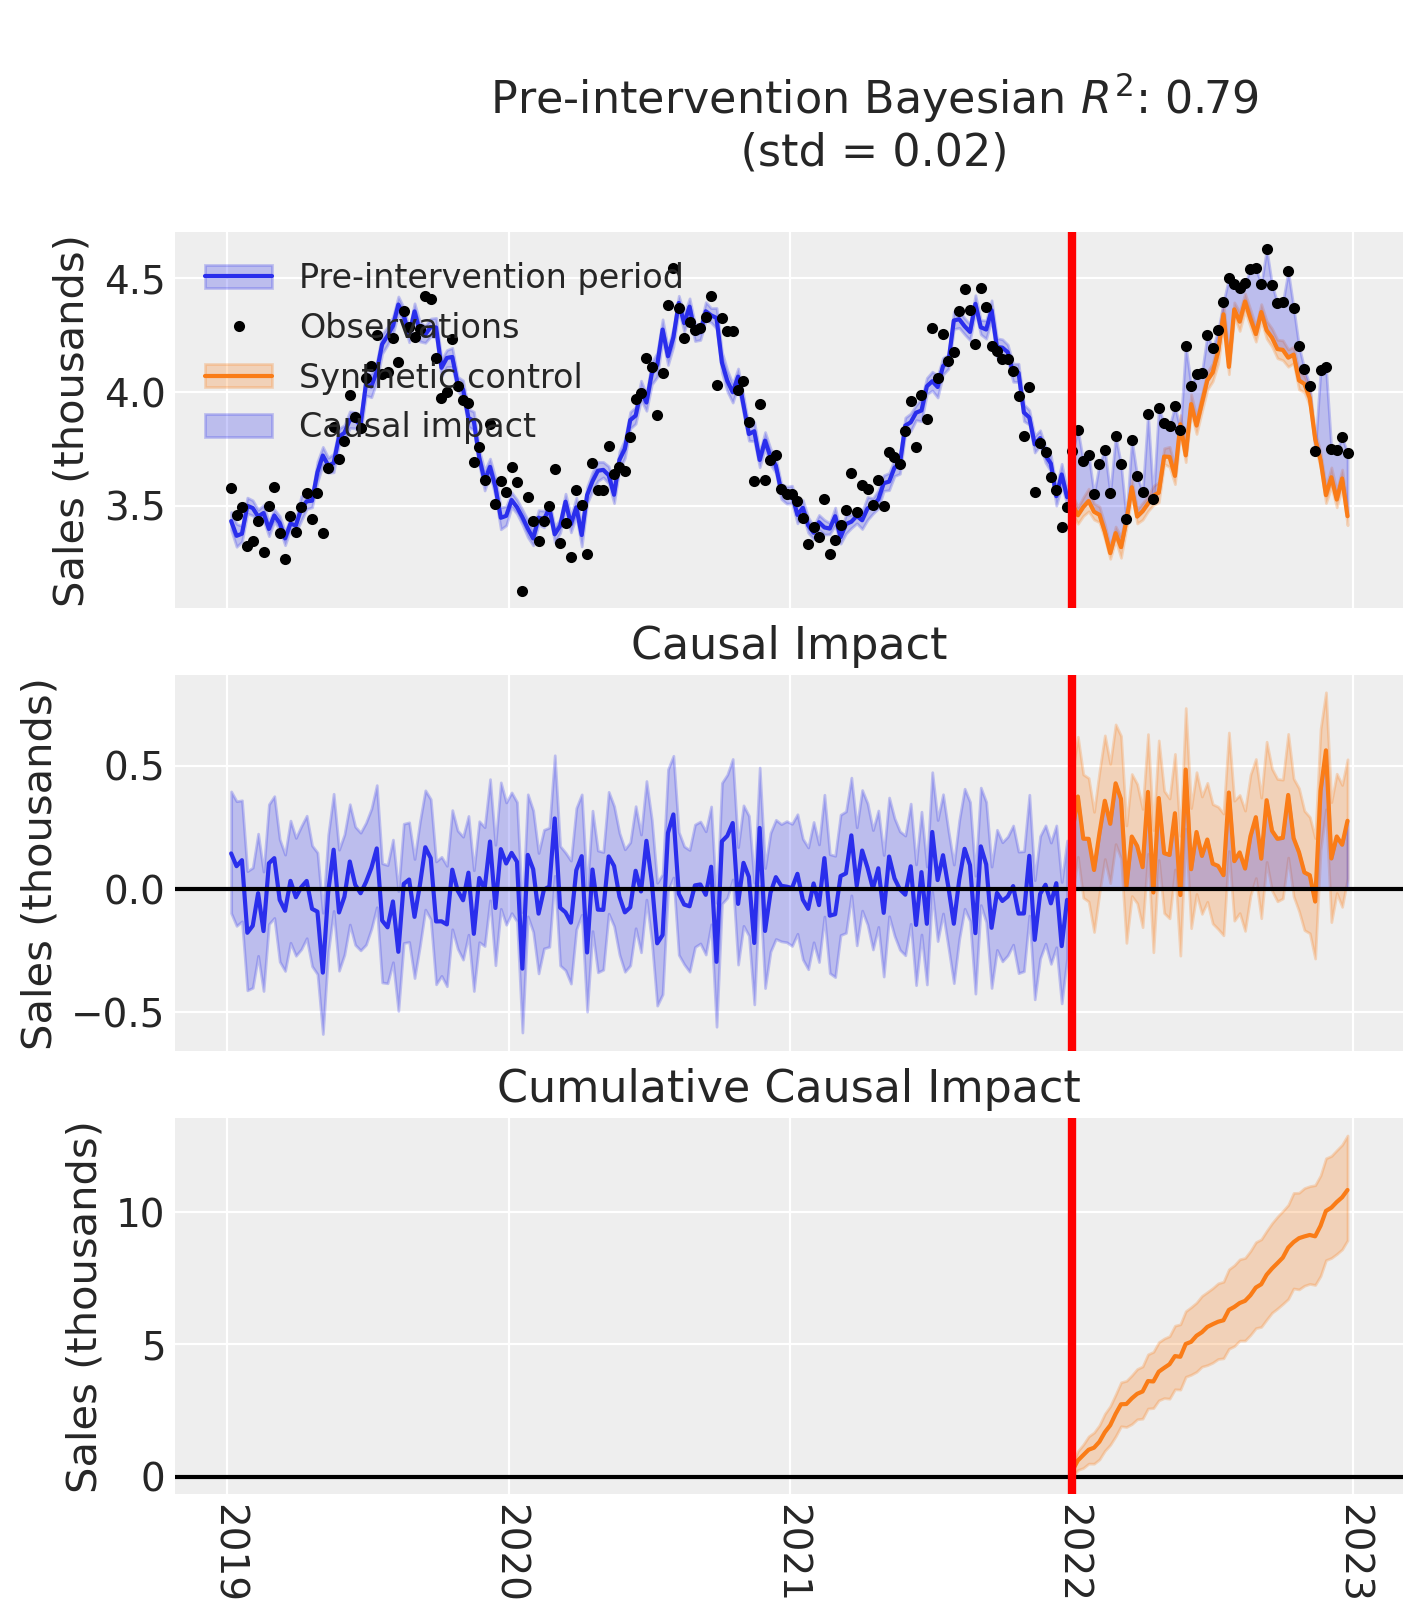

Causal impact for t2


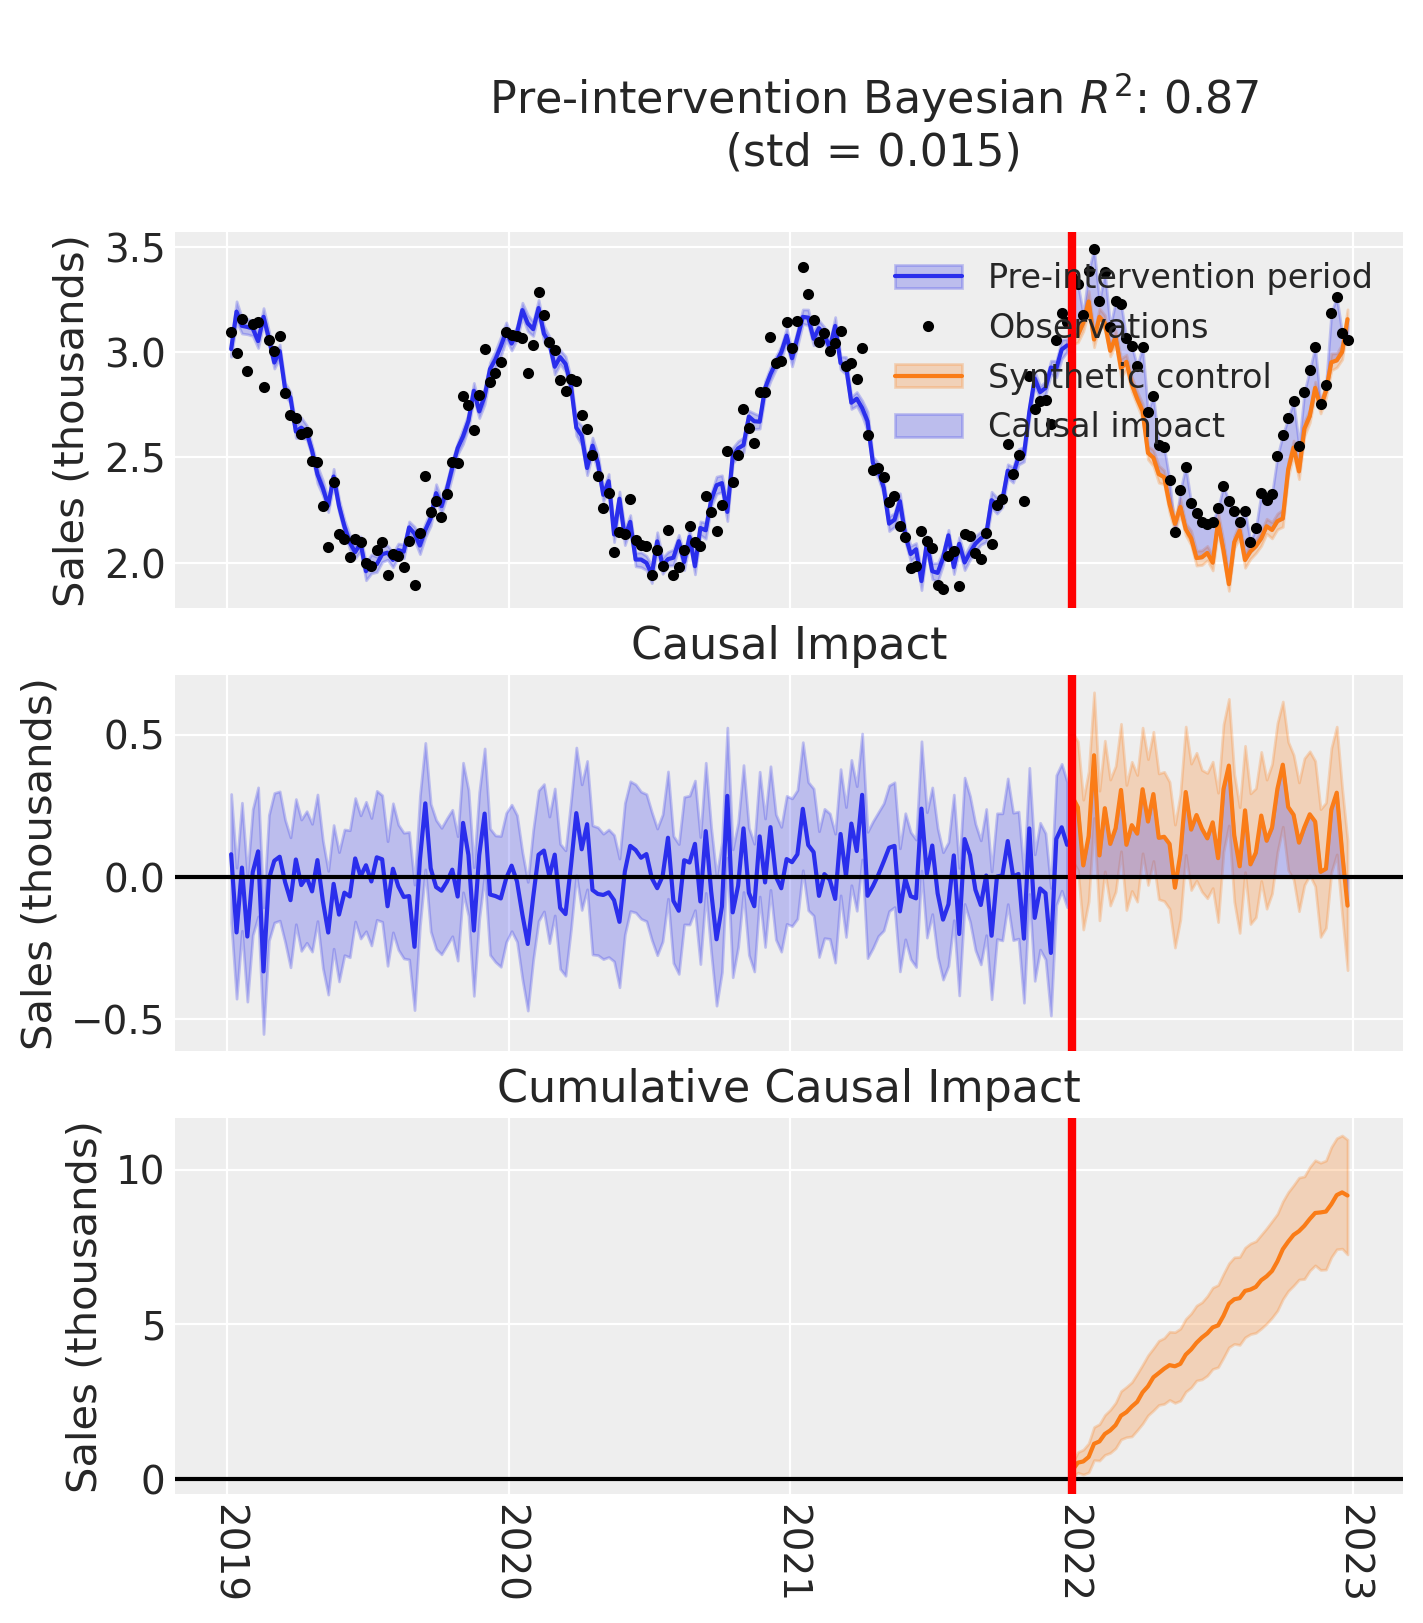

Causal impact for t3


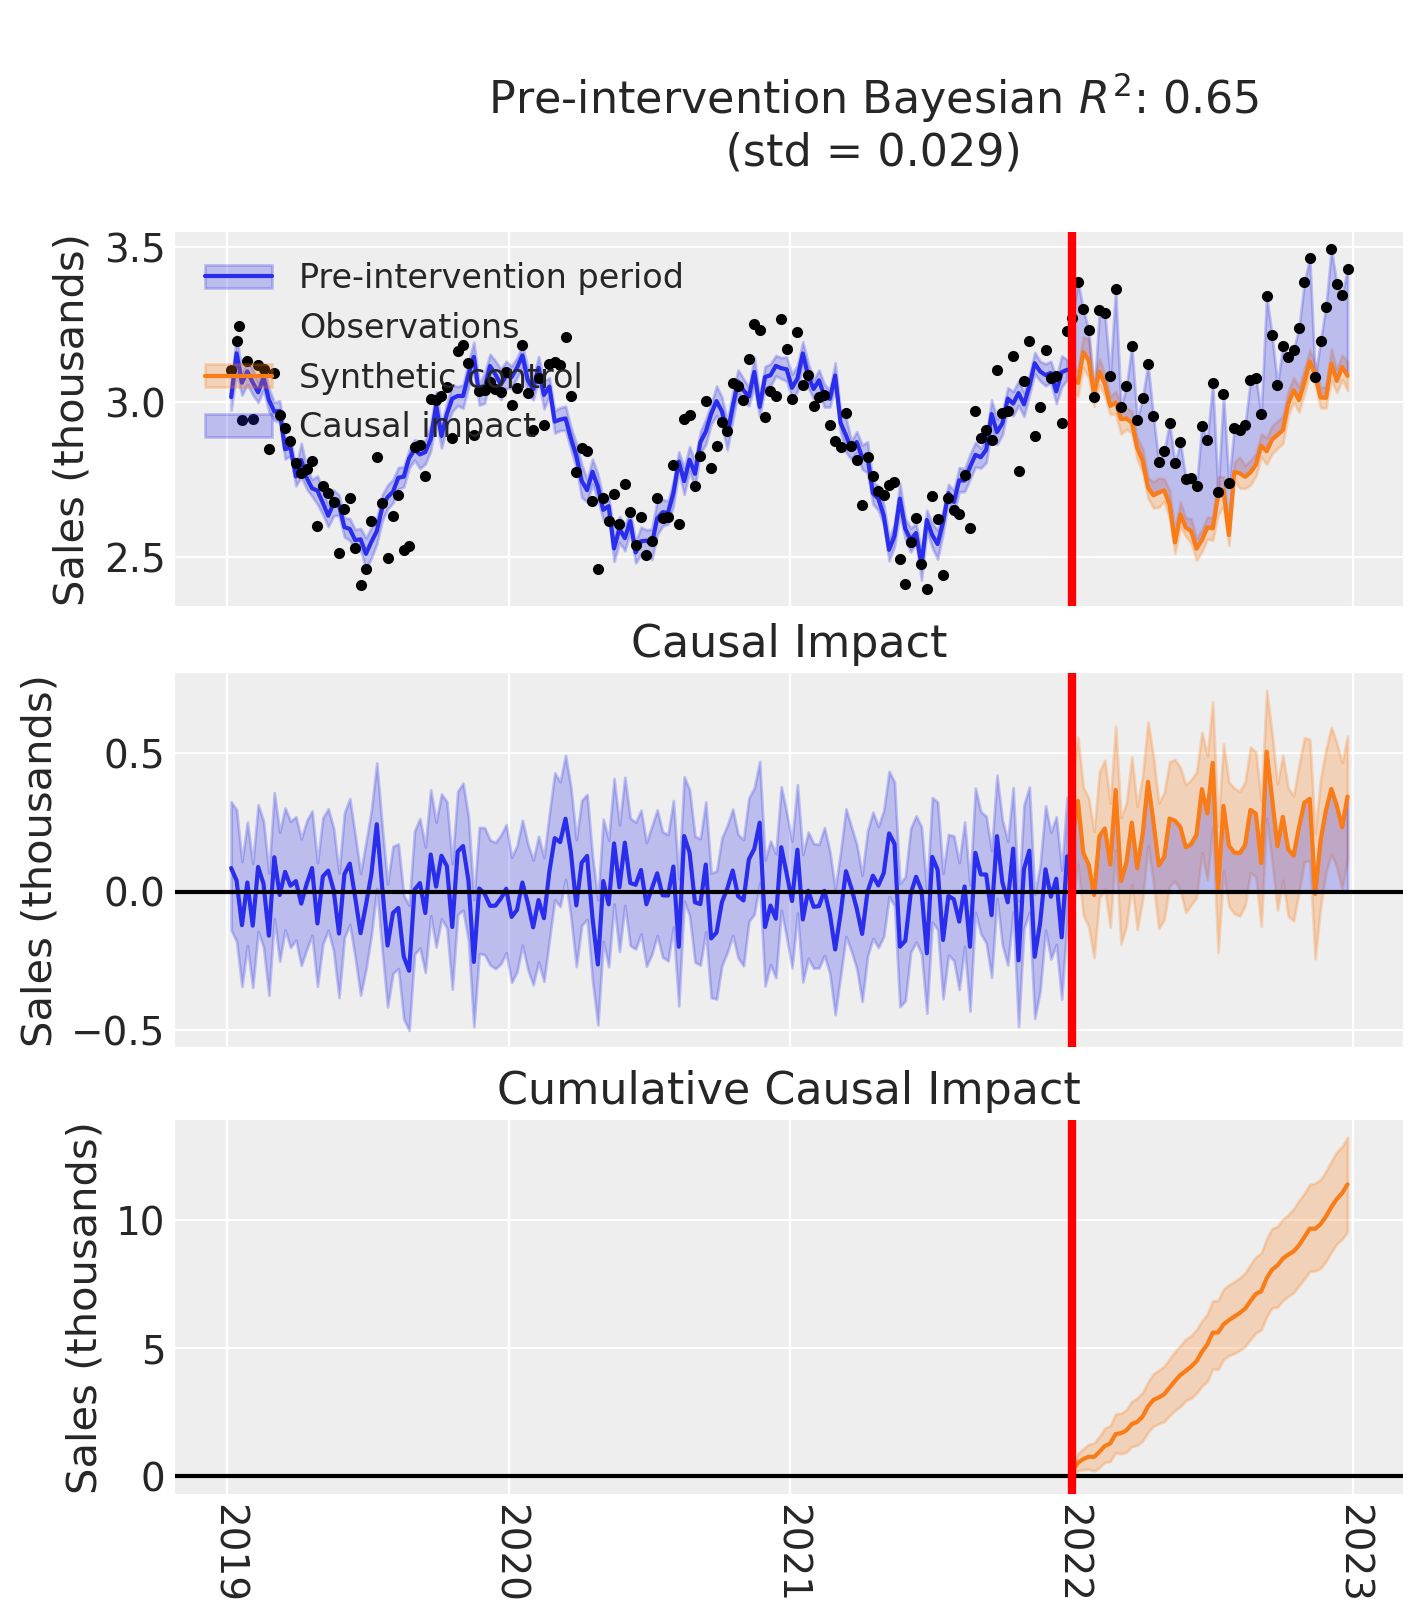

Causal impact for t4


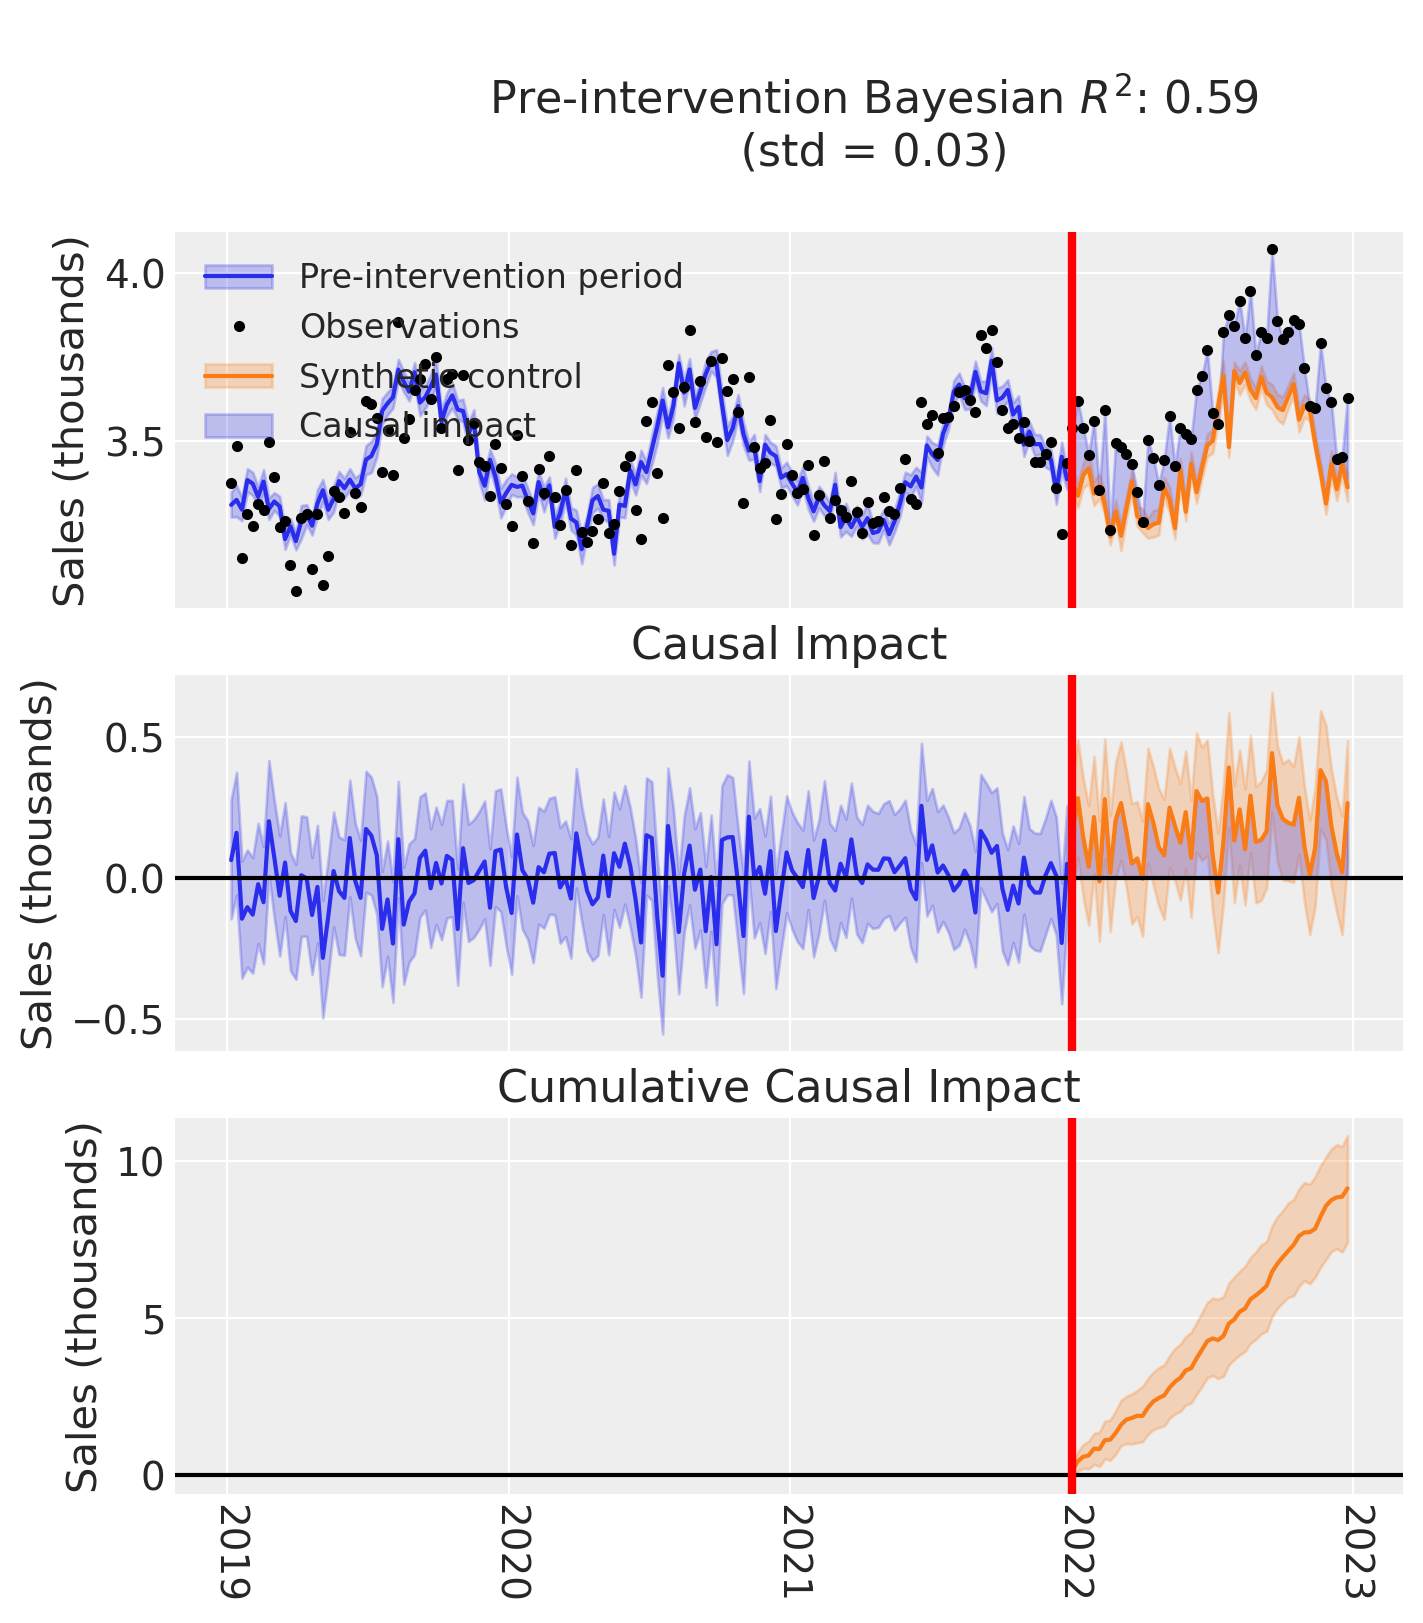

In [11]:
for treated_geo, result in zip(treated, results):

    print(f"Causal impact for {treated_geo}")
    fig, ax = result.plot(plot_predictors=False)

    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sales (thousands)")
    plt.show()

SUMMARY HERE

## Analysis 2 - aggregate geo approach

The second analysis approach is to aggregate the treated geos and analyze them as a group.